<div style="background-color:#000;"><img src="pqn.png"></img></div>

## Library installation
Install the libraries needed to fetch market data, compute realized volatility, and plot the cone so the notebook runs end-to-end.

In [ ]:
!pip install yfinance pandas numpy matplotlib

## Imports and setup
We use math for annualization, yfinance to download daily prices, numpy for vectorized math on returns, and matplotlib.pyplot to visualize the volatility cone.

In [9]:
import math

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

This small stack mirrors what desks use for quick pre-trade checks without heavy dependencies. Keeping tools simple encourages a consistent process, which matters more than model complexity when judging whether options are cheap or rich. Annualizing with math.sqrt(252) aligns our realized metric with how implied volatility is quoted.

## Define cone parameters and collect data
Set the lookback windows we will test and the quantile bands to summarize, and prepare containers to hold each window’s historical stats and the latest realized value.

In [11]:
windows = [30, 60, 90, 120]
quantiles = [0.25, 0.75]

In [12]:
min_ = []
max_ = []
median = []
top_q = []
bottom_q = []
realized = []

Each window maps to a common option tenor, so we can compare realized behavior on the same horizon as the trade. Quantile bands give a robust sense of typical ranges instead of chasing extremes. Preallocating these lists keeps the loop clean and avoids mixing statistics across windows.

Download daily JPM close prices for 2020 using yfinance; this is the raw material for realized volatility.

In [13]:
data = yf.download("JPM", start="2020-01-01", end="2025-12-31")

/var/folders/6m/0ykpdmvn3lb5qkq15hk3s11c0000gn/T/ipykernel_99966/3699040392.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("JPM", start="2020-01-01", end="2025-12-31")
[*********************100%***********************]  1 of 1 completed


We measure realized volatility from what the market actually did rather than guessing. Use trading-day data to stay consistent with the 252-day annualization. In practice, pull enough history to fill the longest window so the most recent estimates are not NaN.

## Compute rolling realized volatility by window
Define a helper that converts rolling log-return variability into annualized realized volatility for a chosen window.

In [14]:
def realized_vol(price_data, window=30):
    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    return log_return.rolling(window=window, center=False).std() * math.sqrt(252)

Log returns make volatility scale-stable across price levels, which is important when comparing periods. Annualizing with the square root of 252 puts realized on the same units as implied volatility. Recomputing this per window builds the cone’s tenor-specific histories.

Evaluate the realized volatility series for each window and summarize its historical distribution into bands.

In [15]:
def _scalar(x):
    # robustly convert Series/ndarray/scalar -> Python float
    return float(np.asarray(x).squeeze())

rows = []
for w in windows:
    est = realized_vol(price_data=data, window=w).dropna()

    rows.append({
        "window": w,
        "Min":      _scalar(est.min()),
        "Max":      _scalar(est.max()),
        "Median":   _scalar(est.median()),
        f"{quantiles[1]*100:.0f} Prctl": _scalar(est.quantile(quantiles[1])),
        f"{quantiles[0]*100:.0f} Prctl": _scalar(est.quantile(quantiles[0])),
        "Realized": _scalar(est.iloc[-1]),
    })

dfw = pd.DataFrame(rows).sort_values("window")

These summaries create a stable yardstick by horizon, which is the core idea of a volatility cone. We also record today’s realized per window to see where it sits within its own historical range. Be mindful of thin history or recent events, which influence short windows more than long ones.

## Visualize volatility cone results clearly
Plot each window’s distribution bands and overlay the latest realized point so we can judge today against history at matching tenors.

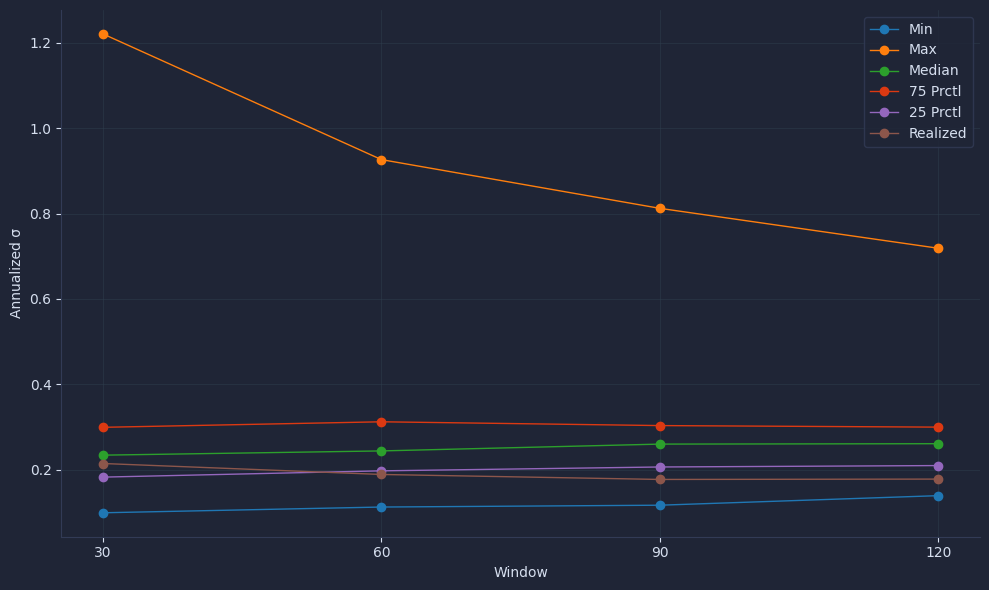

In [16]:
dfw = pd.DataFrame(rows).sort_values("window")
for col in [
    "Min",
    "Max",
    "Median",
    f"{quantiles[1]*100:.0f} Prctl",
    f"{quantiles[0]*100:.0f} Prctl",
    "Realized",
]:
    plt.plot(
        dfw["window"].to_numpy(), dfw[col].to_numpy(), "-o", linewidth=1, label=col
    )
plt.legend()
plt.xlabel("Window")
plt.ylabel("Annualized σ")
plt.xticks(windows)
plt.show()

Read the cone across the x-axis by tenor, not as a time series. If today’s realized is near the lower band while same-tenor implied is high, selling optionality can be justified; the reverse suggests caution or buying vol. Always layer in event context like earnings or macro releases because cones anchor expectations but do not predict jumps.

<a href="https://pyquantnews.com/">PyQuant News</a> is where finance practitioners level up with Python for quant finance, algorithmic trading, and market data analysis. Looking to get started? Check out the fastest growing, top-selling course to <a href="https://gettingstartedwithpythonforquantfinance.com/">get started with Python for quant finance</a>. For educational purposes. Not investment advice. Use at your own risk.